Exercicio extraido do curso "TensorFlow: Machine Learning e Deep Learning com Python", oferecido pelo Prof. Jones Granatyr.
Link do curso: https://www.udemy.com/tensorflow-machine-learning-deep-learning-python/

Adicionado comentários para melhor entendimento.

Buscando o dataset do kaggle

In [2]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"gilbertorocha","key":"4d3618c473ea67622c0399535290b8ff"}
with open('/content/.kaggle/kaggle.json', 'w+') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d gilbertorocha/tensorflowpetr4 -p /content
!unzip \*.zip

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
  0% 0.00/24.1k [00:00<?, ?B/s]
100% 24.1k/24.1k [00:00<00:00, 20.3MB/s]
Archive:  tensorflowpetr4.zip
  inflating: petr4.csv               


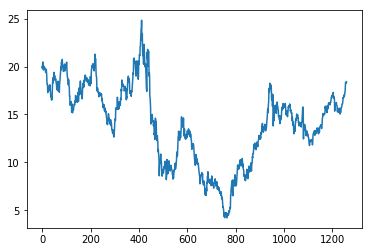

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

base = pd.read_csv('petr4.csv')

base = base.dropna()
#so será utilizado neste exemplo o atributo open
base = base.iloc[:,1].values

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(base)
plt.show()

In [0]:
# define o periodo que será feito a previsao (em dias)
periodos = 30
# horizonte das previsões, ou seja, indica quantos periodos será utilizado, ficando o valor total como previsao_futura * periodos
previsao_futura = 1

# previsores
# divisão de base de dados de treinamento e teste

# criação dos batchs para processamento
# gera 41 conjuntos com 30 registros cada
# A ideia é fazer uma divisão manual, ao invés de usar os recursos do sklearn, para "adiantar" no y um valor
# A intenção é fazer o x possuir um periodo de 30 valores, e o y também, no entanto o y vai estar sempre com 1 valor a frente
# desta forma a rede entende que se passando 30 valores de x, a sua previsão após o ultimo valor do lote (primeira posição de x na "linha" subsequente a atual), 
# vai ser o valor de posição 30 da "linha" atual
x = base[0:(len(base) - (len(base) % periodos))]

x_batches = x.reshape(-1, periodos, 1)

# adianta um para frente
y = base[1:(len(base) - (len(base) % periodos)) + previsao_futura]
y_batches = y.reshape(-1, periodos, 1)

# pega os ultimos registros para testar
x_teste = base[-(periodos + previsao_futura):]
# elimina o ultimo registro, pois estamos montando batch de 30, e aqui vai ter 31
x_teste = x_teste[:periodos]
x_teste = x_teste.reshape(-1, periodos, 1)
# pega os ultimos 30 registros, ficando sempre "1 a frente" do x
y_teste = base[-(periodos):]
y_teste = y_teste.reshape(-1, periodos, 1)


In [0]:
import tensorflow as tf


In [0]:
# com redes neurais recorrentes é importante resetar os grafos já criados, para não ficar nada em memoria
tf.reset_default_graph()

# possui apenas um atributo previsor
entradas = 1

# nao segue a formula de redes neuras densas ((entradas + saidas) / 2), neste caso tem que ser feito testes
neuronios_oculta = 100

# so tem uma saida, uma vez que é uma regressão e retorna um numero
neuronios_saida = 1

# para os placeholders e informado:
#     Formato = Formato dos dados, no caso tf.float32 
#     Batch_size = None, vai ser definido em outra etapa
#     Periodos = quantos periodos será executado
#     entradas = quantidade de entradas (ou saidas) esperada
xph = tf.placeholder(tf.float32, [None, periodos, entradas])
yph = tf.placeholder(tf.float32, [None, periodos, neuronios_saida])


# Celula, é a estrutura da rede recorrente, que fica criando o loop que repassas as informações
# a ela mesma.
# Cada uma das celulas indica uma camada oculta na rede
# Aqui foi criada uma celula simples, é possivel criar outras conforme necessidade
# Criado um metodo que retorna a celula, para poder reutilizar quando fizer uma rede maior

def cria_uma_celula_simples():
  # num_units = numero de neuronios para a camada oculta
  # activation = formula de saida
  return tf.contrib.rnn.BasicRNNCell(num_units = neuronios_oculta, activation = tf.nn.relu)

def cria_varias_celulas_simples(num_celulas, num_drop_out):
  # usa uma função para agrupar celulas do proprio TensorFlow, e chama a criar celula simples em um laço
  celulas = tf.nn.rnn_cell.MultiRNNCell([cria_uma_celula_simples() for i in range(num_celulas)])
  # usa o dropout, que vai zerar algumas entradas para evitar o overtifing
  # passa o valor 1 para 100%, e uma fração para o percentual correspondente
  if num_drop_out > 0:
    return tf.contrib.rnn.DropoutWrapper(celulas, output_keep_prob = num_drop_out)
  else:
    return tf.contrib.rnn.DropoutWrapper(celulas)

# Cria uma celula do tipo Long short memory (mais complexa)
def cria_uma_celula_lstm():
  # num_units = numero de neuronios para a camada oculta
  # activation = formula de saida
  return tf.contrib.rnn.LSTMCell(num_units = neuronios_oculta, activation = tf.nn.relu)
  
def cria_varias_celulas_lstm(num_celulas, num_drop_out):
  # usa uma função para agrupar celulas do proprio TensorFlow, e chama a criar celula simples em um laço
  celulas = tf.nn.rnn_cell.MultiRNNCell([cria_uma_celula_lstm() for i in range(num_celulas)])
  # usa o dropout, que vai zerar algumas entradas para evitar o overtifing
  # passa o valor 1 para 100%, e uma fração para o percentual correspondente
  if num_drop_out > 0:
    return tf.contrib.rnn.DropoutWrapper(celulas, output_keep_prob = num_drop_out)
  else:
    return tf.contrib.rnn.DropoutWrapper(celulas)


#celula = cria_uma_celula_simples()
#celula = cria_varias_celulas_simples(4, 0.1)
#celula = cria_uma_celula_lstm()
celula = cria_varias_celulas_lstm(4, 0.0)

# Apos criar a camada oculta, liga ela na camada de saida
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size = 1)
# Pega as previsões
# É usado uma rede dinamica
# Passando apenas a celula como camada oculta
# O placeholder para alimentar os dados
# O tipo dos dados
saida_rnn, _ = tf.nn.dynamic_rnn(celula, xph, dtype = tf.float32)

# Agora com as saidas, é calculado o erro
# Labels = as classes esperadas
# Predictions = as previsões geradas pela rnn
erro = tf.losses.mean_squared_error(labels = yph, predictions = saida_rnn)

# Monta o optimizador
otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)

# Otimiza de fato
treinamento = otimizador.minimize(erro)

In [12]:
# Executando a rede recorrente
with tf.Session() as sess:
  # inicializa as variaveis
  sess.run(tf.global_variables_initializer())
  
  # executa pelo numero de epocas
  for epoca in range(1000):
    #roda a rede, passando a propria rede, o erro
    # feed_dict serve para alimentar o x e y configurados na rede
    _, custo = sess.run([treinamento, erro], feed_dict = {xph: x_batches, yph: y_batches})
    # mostra a epoca a cada 100, junto com demais informações
    if epoca % 100 == 0:
      print(epoca + 1, ' erro: ', custo)
  
  previsoes = sess.run(saida_rnn, feed_dict = {xph: x_teste})


1  erro:  213.24297
101  erro:  19.336252
201  erro:  6.0774293
301  erro:  0.87001926
401  erro:  0.42828688
501  erro:  0.43043104
601  erro:  0.1860549
701  erro:  0.16286062
801  erro:  0.13873838
901  erro:  0.14810024


In [13]:
# algumas transformações para poder comparar o resultado das previsões com o real
import numpy as np
y_teste.shape
#como esta no formato (1, 30, 1) diminuimos para apenas 30 (removendo as "camadas" de array), para ficar mais facil de comparar
y_teste2 = np.ravel(y_teste)

previsoes2 = np.ravel(previsoes)


# calcula o erro 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste2, previsoes2)
# neste teste esta errando 0.16 centavos
print(mae)



0.40424666677246157


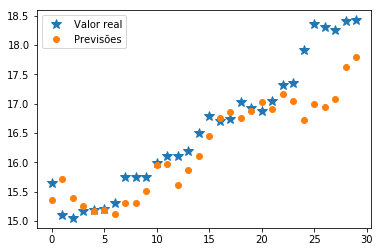

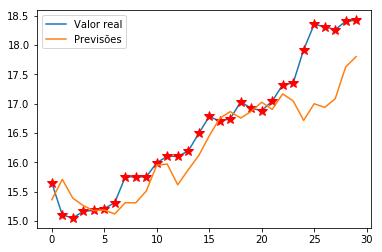

In [14]:
#visualizar os resultados
plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
plt.plot(previsoes2, 'o', label = 'Previsões')
plt.legend()
plt.show()


# em formato de linha
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()
plt.show()